In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Generate training data
def generate_data(num_samples=1000):
    x = np.random.uniform(-1, 1, (num_samples, 2))
    y = np.sum(x**2, axis=1, keepdims=True)
    return x, y

# Generate training and validation data
x_train, y_train = generate_data(1000)
x_val, y_val = generate_data(200)

# Define the model with skip connections
input_layer = Input(shape=(2,), name='INPUT')

# First hidden layer with skip connection
hidden1 = Dense(64, activation='relu', name='FC1')(input_layer)

# Second hidden layer with skip connection
hidden2 = Dense(64, name='FC2')(hidden1)
skip2 = Dense(64, use_bias=False, name='SKIP2')(input_layer)
hidden2 = Add(name='SUM')([hidden2, skip2])
hidden2 = Activation('relu', name='Z2')(hidden2)

# Output layer with skip connection
output_layer = Dense(1, name='FC3')(hidden2)
skip_output = Dense(1, use_bias=False, name='SKIP3')(input_layer)
output_layer = Add(name='Z3')([output_layer, skip_output])

model = Model(inputs=input_layer, outputs=output_layer)

# Initialize the optimizer
optimizer = Adam(learning_rate=0.001)

# Training parameters
epochs = 20
batch_size = 32
steps_per_epoch = x_train.shape[0] // batch_size

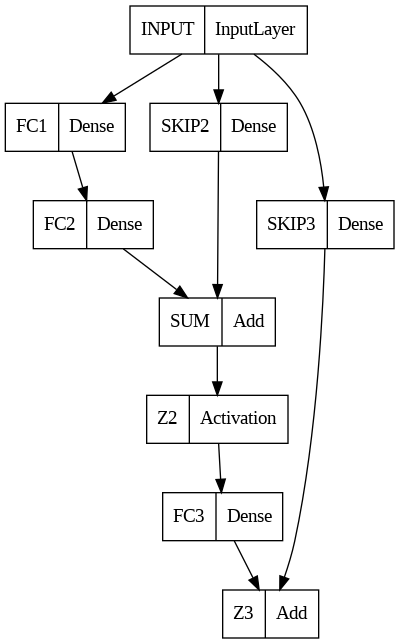

In [4]:
tf.keras.utils.plot_model(model, "my_first_model.png")

In [5]:
for layer in model.layers:
    if hasattr(layer, 'use_bias'):
        print(f"Layer {layer.name} has bias: {layer.use_bias}")
    else:
        print(f"Layer {layer.name} doesn't have bias")

Layer INPUT doesn't have bias
Layer FC1 has bias: True
Layer FC2 has bias: True
Layer SKIP2 has bias: False
Layer SUM doesn't have bias
Layer Z2 doesn't have bias
Layer FC3 has bias: True
Layer SKIP3 has bias: False
Layer Z3 doesn't have bias


In [6]:
# Training loop
for epoch in range(epochs):
    for step in range(steps_per_epoch):
        # Get a batch of training data
        x_batch = x_train[step*batch_size:(step+1)*batch_size]
        y_batch = y_train[step*batch_size:(step+1)*batch_size]

        with tf.GradientTape() as tape:
            # Forward pass
            y_pred = model(x_batch, training=True)
            # Compute the loss
            loss = tf.reduce_mean(tf.losses.mean_squared_error(y_batch, y_pred))

        # Compute the gradients
        gradients = tape.gradient(loss, model.trainable_variables)
        # Apply the gradients to the optimizer
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Project the hidden layer weights to be non-negative
        for layer in model.layers[2:]:
            if hasattr(layer, 'use_bias') and layer.use_bias:
                weights = layer.get_weights()
                weights[0] = np.maximum(weights[0], 0)  # Project weights to be non-negative
                layer.set_weights(weights)

    # Compute validation loss
    y_val_pred = model(x_val, training=False)
    val_loss = tf.reduce_mean(tf.losses.mean_squared_error(y_val, y_val_pred))

    print(f'Epoch {epoch+1}, Validation Loss: {val_loss.numpy()}')

# Evaluate the model
y_val_pred = model(x_val, training=False)
val_loss = tf.reduce_mean(tf.losses.mean_squared_error(y_val, y_val_pred))
print(f'Final Validation Loss: {val_loss.numpy()}')

# Test the model on a new sample
x_test = np.array([[0.5, -0.5]])
y_test = model(x_test)
print(f'Prediction for {x_test}: {y_test.numpy()}, Expected: {np.sum(x_test**2, axis=1)}')


Epoch 1, Validation Loss: 0.09370115399360657
Epoch 2, Validation Loss: 0.04324670881032944
Epoch 3, Validation Loss: 0.029693756252527237
Epoch 4, Validation Loss: 0.021280432119965553
Epoch 5, Validation Loss: 0.016234420239925385
Epoch 6, Validation Loss: 0.013050614856183529
Epoch 7, Validation Loss: 0.01092018373310566
Epoch 8, Validation Loss: 0.009398403577506542
Epoch 9, Validation Loss: 0.008256553672254086
Epoch 10, Validation Loss: 0.007362608332186937
Epoch 11, Validation Loss: 0.006642209365963936
Epoch 12, Validation Loss: 0.006048844661563635
Epoch 13, Validation Loss: 0.005558711476624012
Epoch 14, Validation Loss: 0.005147214978933334
Epoch 15, Validation Loss: 0.004786950070410967
Epoch 16, Validation Loss: 0.004461753182113171
Epoch 17, Validation Loss: 0.004172410350292921
Epoch 18, Validation Loss: 0.003914167173206806
Epoch 19, Validation Loss: 0.0036702908109873533
Epoch 20, Validation Loss: 0.003448484232649207
Final Validation Loss: 0.003448484232649207
Predict

313/313 [==============================] - 1s 4ms/step


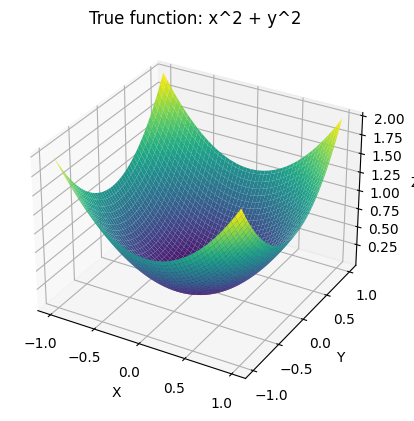

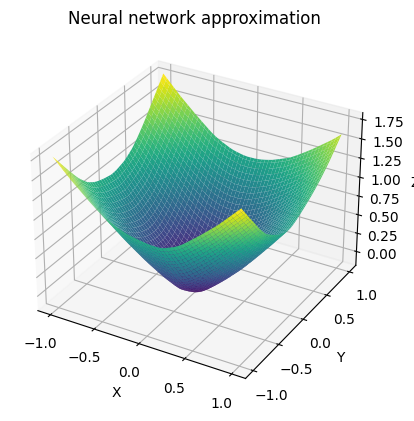

In [7]:
# Visualize the function output and the neural network output as 3D graphs
def plot_3d(x, y, z, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# Generate grid data for visualization
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
x_grid, y_grid = np.meshgrid(x, y)
xy_grid = np.stack([x_grid.flatten(), y_grid.flatten()], axis=-1)

# Compute true function values
z_true = np.sum(xy_grid**2, axis=1).reshape(x_grid.shape)

# Compute neural network predictions
z_pred = model.predict(xy_grid).reshape(x_grid.shape)

# Plot the true function
plot_3d(x_grid, y_grid, z_true, 'True function: x^2 + y^2')

# Plot the neural network approximation
plot_3d(x_grid, y_grid, z_pred, 'Neural network approximation')

In [8]:
# Iterate through the layers
for i, layer in enumerate(model.layers):
    # Print layer name
    print(f"Layer {i}: {layer.name}")

    # Get layer parameters
    weights = layer.get_weights()

    # Check if layer has parameters
    if weights:
        # Print parameter container sizes
        for w in weights:
            print(f"    Parameter shape: {w.shape}")
            print(f"    All non-negative: {tf.reduce_all(tf.greater_equal(w, 0))}")
    else:
        print("    No parameters")

    # Print use_bias
    if hasattr(layer, 'use_bias'):
        print(f"    use_bias: {layer.use_bias}")
    else:
        print("    No use_bias attribute")

Layer 0: INPUT
    No parameters
    No use_bias attribute
Layer 1: FC1
    Parameter shape: (2, 64)
    All non-negative: False
    Parameter shape: (64,)
    All non-negative: False
    use_bias: True
Layer 2: FC2
    Parameter shape: (64, 64)
    All non-negative: True
    Parameter shape: (64,)
    All non-negative: False
    use_bias: True
Layer 3: SKIP2
    Parameter shape: (2, 64)
    All non-negative: False
    use_bias: False
Layer 4: SUM
    No parameters
    No use_bias attribute
Layer 5: Z2
    No parameters
    No use_bias attribute
Layer 6: FC3
    Parameter shape: (64, 1)
    All non-negative: True
    Parameter shape: (1,)
    All non-negative: False
    use_bias: True
Layer 7: SKIP3
    Parameter shape: (2, 1)
    All non-negative: True
    use_bias: False
Layer 8: Z3
    No parameters
    No use_bias attribute


In [9]:
import json

In [10]:
# Extract the weights as matrices
layer_names = ['FC1', 'FC2', 'FC3', 'SKIP2', 'SKIP3']
weights = {layer_name: model.get_layer(layer_name).get_weights() for layer_name in layer_names}

# Save weights to JSON
weights_json = {layer_name: [w.tolist() for w in weight_matrices] for layer_name, weight_matrices in weights.items()}
with open('model_weights.json', 'w') as json_file:
    json.dump(weights_json, json_file)